In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-16 23:02:12.628440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 10)           2570        ['dense_1[0][0]']                
                                                                                            

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270,096
Trainable params: 270,096
Non-trainable params: 0
_________________________________________________________________


## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 222.6915
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 140.3836
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 126.2148
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 120.1752
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 116.5744
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 114.1462
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 112.6509
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 111.2697
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 109.8612
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 109.0799


## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])

313/313 [==============================] - 0s 885us/step


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

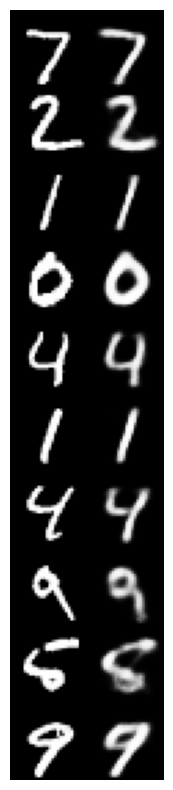

In [17]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [ ]:
# use z_test_pred

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2)

In [21]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

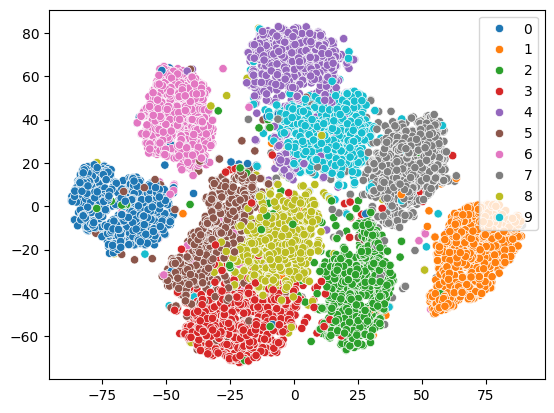

In [22]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

1/1 [==============================] - 0s 32ms/step


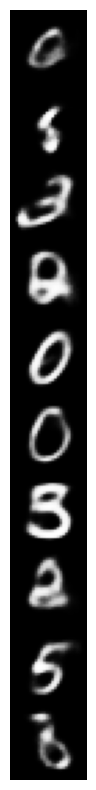

In [23]:
p_z = np.random.normal(0, 1, (10, 10))
pred_z = vae.decoder.predict(p_z)
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size,:] = pred_z[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# Task 2

In [124]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [125]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

original_dim = x_train.shape[1]

x_train = np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1)
x_test = np.concatenate([x_test, y_test.reshape(-1, 1)], axis=1)


In [74]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim + 1, ))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 785)]        0           []                               
                                                                                                  
 dense_47 (Dense)               (None, 256)          201216      ['input_20[0][0]']               
                                                                                                  
 dense_48 (Dense)               (None, 256)          65792       ['dense_47[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 10)           2570        ['dense_48[0][0]']               
                                                                                            

In [75]:
latent_inputs = keras.Input(shape=(latent_dim + 1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_49 (Dense)            (None, 256)               3072      
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 784)               201488    
                                                                 
Total params: 270,352
Trainable params: 270,352
Non-trainable params: 0
_________________________________________________________________


In [78]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            c = tf.reshape(data[:, -1], (-1, 1))
            x = data[:, :-1]
            z = tf.concat([z, c], axis = 1)
            reconstruction = self.decoder(z)
            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()} 

In [90]:
cvae = cVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 102.6819
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 102.3033
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 101.8662
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 101.7990
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 101.7590
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 101.5269
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 101.4249
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 101.1132
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 100.8553
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 100.5980


## f)

In [128]:
z_test_pred = cvae.encoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [129]:
z_test_pred = np.concatenate([z_test_pred[2],y_test.reshape(-1,1)],axis=1)
test_pred = cvae.decoder.predict(z_test_pred)

313/313 [==============================] - 0s 922us/step


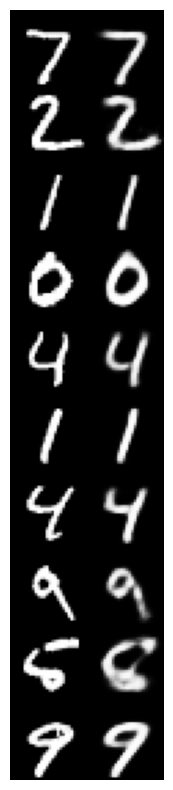

In [130]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[:,:-1][i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [134]:
tsne = TSNE(n_components=2)

In [136]:
z_test_pred = z_test_pred[:, :-1]
z_test_pred_tsne = tsne.fit_transform(z_test_pred)

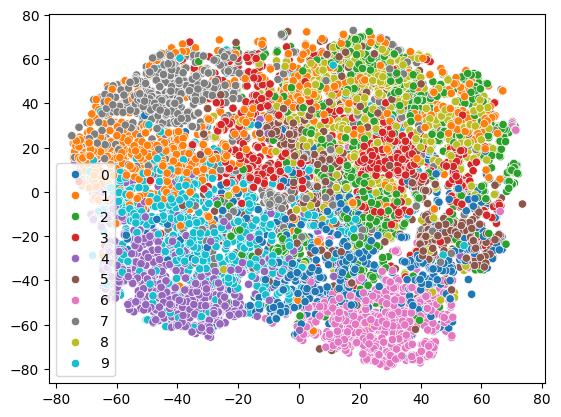

In [137]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [154]:
rand = np.random.normal(0, 1, (10, 10))
new_pred = np.zeros((10, 1))
rand = np.concatenate([rand, new_pred], axis=1)
new_pred = cvae.decoder.predict(rand)

1/1 [==============================] - 0s 21ms/step


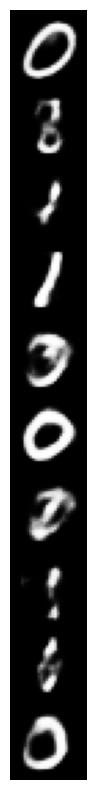

In [155]:
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n,digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size,:] = new_pred[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()